# Machine Learning using Regularized Logistic Regression

Classifier model that predict whether microchips from a fabrication plant passes quality assurance (QA).

In [1]:
import pandas as pd
import numpy as np
# import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('ex2data2.txt', names = ['test1', 'test2', 'accepted'])
data = data.astype('float128')
print('Profiling Data')
print(data.info())
print(data.head())

# profile = pandas_profiling.ProfileReport(df)
# profile.to_file(outputfile="output.html")

Profiling Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float128
test2       118 non-null float128
accepted    118 non-null float128
dtypes: float128(3)
memory usage: 5.6 KB
None
      test1    test2  accepted
0  0.051267  0.69956       1.0
1 -0.092742  0.68494       1.0
2 -0.213710  0.69225       1.0
3 -0.375000  0.50219       1.0
4 -0.513250  0.46564       1.0


In [3]:
x = np.array(data[['test1', 'test2']]) # training set
y = np.array(data['accepted']) # labels
[m, n] = np.shape(x)

## ==================== Part 1: Plotting ====================

The plot bellow shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

Plotting data with "x" indicating (y = 1) examples and "o" indicating (y = 0) examples.


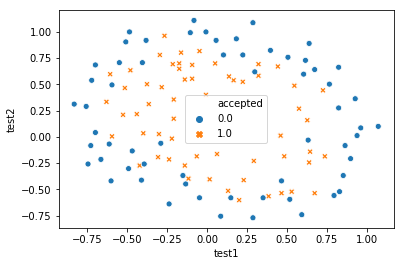

In [4]:
print('Plotting data with "x" indicating (y = 1) examples and "o" indicating (y = 0) examples.')
sns.scatterplot('test1', 'test2', hue='accepted', style='accepted', data=data)

## =========== Part 2: Mapping Features ============

One way to fit the data better is to create more features from each data point. We will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. To void that we will implement regularized logistic regression to fit the data and combat the overfitting problem.

In [5]:
"""
Maps the two input features to quadratic features used in the regularization.
Returns a new feature array with more features, comprising of [1, X1, X2, X1^2, X2^2, X1*X2, X1*X2^2, etc].
Inputs x1, x2 must be the same size.
x1 = [
    [],
    ...
]
x2 = [
    [],
    ...
]
Return [
    [1, x1, x2, x1^2, x2^2, x1*x2, x1*x2^2, etc]
    ...
]
"""
def mapFeature(x1, x2):
    assert(len(x1) == len(x2))
    degree = 6
    out = [[1] for i in range(len(x1))]
    
    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            for k in range(len(x1)):
                out[k].append((x1[k][0] ** (i - j)) * (x2[k][0] ** j))
    
    return np.array(out)

In [6]:
"""
Normalizes the features in X 
returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1.
This is often a good preprocessing step to do when working with learning algorithms.

First, for each feature dimension, compute the mean of the feature and subtract it from the dataset,
storing the mean value in mu. Next, compute the  standard deviation of each feature and divide
each feature by it's standard deviation, storing the standard deviation in sigma.
"""
def featureNormalize(X):
    X_norm = np.zeros(np.shape(X))
    qty_features = np.shape(X)[1]
    mu = np.zeros(qty_features)
    sigma = np.zeros(qty_features)
    
    for i in range(qty_features):
        mu[i] = np.mean(X[:,i])
        X_norm[:,i] = X[:,i] - mu[i]
        
        # by default np.std calculate the population std, here we want sample std (as done in Octave)
        sigma[i] = np.std(X_norm[:,i], ddof=1) # default: ddof=0 (N - 0) will predict 293092.21273075533
        X_norm[:,i] = X_norm[:,i] / sigma[i]
    return X_norm, mu, sigma

## =========== Part 3: Regularized Logistic Regression ============

### Activation Function
We will use the sigmoid function as our activation function.

$g(z) = \frac{1}{1 + e^{-z}}$

When:

$z = 0$ then $g = 0.5$

$z \rightarrow +\infty$ then $g \rightarrow +1$

$z \rightarrow -\infty$ then $g \rightarrow 0$

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
print(sigmoid(-5)) # ~= 0.0066929
print(sigmoid(0)) # ~= 0.5
print(sigmoid(5)) # ~= 0.99331
print(sigmoid(np.array([4, 5, 6]))) # ~= [0.98201   0.99331   0.99753]
print(sigmoid(np.array([-1, 0, 1]))) # ~= [0.26894 0.50000 0.73106]
print(sigmoid(np.array([[4, 5, 6], [-1, 0, 1]])))

0.0066928509242848554
0.5
0.9933071490757153
[0.98201379 0.99330715 0.99752738]
[0.26894142 0.5        0.73105858]
[[0.98201379 0.99330715 0.99752738]
 [0.26894142 0.5        0.73105858]]


### Hypothesis Function
Function that defines our logistic model.

Definition:

$h_\theta(x) = g(\theta_0 + \theta_1 * x_1 + \theta_2 * x_2)$

Vectorial form:

$h_\theta(x) = g(\theta^{T} * x)$

where:

$g$ is the sigmoid function; $x = [x_0, x_1, x_2]$; $x_0 = 1$ and $\theta = [\theta_0, \theta_1, \theta_2]$

In [9]:
def hypothesis(X, theta):
    z = X.dot(theta)
    return sigmoid(z)

### Regularized Logistic Cost Function
Computes the logistic cost of our model using theta as the parameter for logistic regression to fit the data points in X and y, considering the cost of a particular choice of theta.

For parameter $\theta_0$ we aren't computing its cost because it is the bias - doesn't have a feature.

Function cost:

$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)} log(h_\theta(x^{(i)}) - (1 - y^{(i)}) log(1 - h_\theta(x^{(i)})) ] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^{2}$

Vectorial form:

$ J(\theta) = [\frac{1}{m} * (-\vec{y}^{T} \cdot log(h_\theta(\vec{x})) - (1 - \vec{y})^{T} \cdot log(1 - h_\theta(\vec{x})))] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^{2} $

If any time we got a $log(h_\theta(x^{(i)})) = 0$ that means we need to normalize the features.

In [10]:
"""
Inputs:
X = [
  [ x_0, x_1, ..., x_n ]
]
y = [
  [ y_0 ]
  ...
  [ y_m ]
]
theta = [ theta_0, ..., theta_n ]
lambda = regularization parameter
"""
def computeRegularizedLogisticCostIterative(X, y, theta, lambd):
    m = len(y)
    errorSum = 0 # total error
    for i in range(m):
        h = hypothesis(X[i], theta)
        errorSum = errorSum + (-y[i] * np.log(h) - (1 - y[i]) * np.log(1 - h))

    # sum the square of parameters cost
    parameterCost = 0
    for i in range(1, len(theta)):
        parameterCost = parameterCost + (theta[i] ** 2)
    return errorSum / m + (lambd / (2 * m) * parameterCost)

# Better way using Matrix/Vectors
def computeRegularizedLogisticCostMatrix(X, y, theta, lambd):
    m = len(y)
    h = hypothesis(X, theta)
    return ((1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h)))) \
        + (lambd / (2 * m) * theta[1:].T.dot(theta[1:]))

In [11]:
print('Testing regularized cost function')
X_ = np.array([
    [1, 8, 1, 6],
    [1, 3, 5, 7],
    [1, 4, 9, 2]
]);
y_ = np.array([1, 0, 1]);
theta_ = np.array([-2, -1, 1, 2]);

print('J ~= 4.6832 ->', computeRegularizedLogisticCostIterative(X_, y_, theta_, 0))
print('J ~= 4.6832 ->', computeRegularizedLogisticCostMatrix(X_, y_, theta_, 0))
print('J ~= 8.6832 ->', computeRegularizedLogisticCostIterative(X_, y_, theta_, 4))
print('J ~= 8.6832 ->', computeRegularizedLogisticCostMatrix(X_, y_, theta_, 4))

Testing regularized cost function
J ~= 4.6832 -> 4.683166549810689
J ~= 4.6832 -> 4.683166549810689
J ~= 8.6832 -> 8.68316654981069
J ~= 8.6832 -> 8.68316654981069


In [12]:
# map the features and also add 1s at x_0
# X, mu, sigma = featureNormalize(x)
X = mapFeature(x[:,0].reshape(m, 1), x[:,1].reshape(m, 1))
n = X.shape[1]
initial_theta = np.zeros([n])
# Set regularization parameter lambda to 1
lambd = 1;

#initial_theta = np.array([0.1, 12.00921659, 11.26284221], dtype=np.float128)
cost = computeRegularizedLogisticCostMatrix(X, y, initial_theta, lambd)
print('Cost at initial theta (zeros):', cost)
print('Expected cost (approx): 0.693')

test_theta = np.ones([X.shape[1]])
cost = computeRegularizedLogisticCostMatrix(X, y, test_theta, 10)
print('\nCost at test theta (with lambda = 10):', cost);
print('Expected cost (approx): 3.16');

Cost at initial theta (zeros): 0.69314718055994530704
Expected cost (approx): 0.693

Cost at test theta (with lambda = 10): 3.1645093316152190256
Expected cost (approx): 3.16


### Regularized Gradient Descent
Performs gradient descent to learn $\theta$ parameters.

It return an array with $\theta$ containing the values found by taking num_iters gradient steps with learning rate $\alpha$.

Also it return an array with the history of $J(\theta)$ to be plotted.

Step to update each parameter:

$\theta_j := \theta_j - \alpha * \frac{\partial J}{\partial \theta_j} $

Where:

$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} [( h_\theta(x^{(i)}) - y^{(i)}) * x^{(i)}] + \frac{\lambda}{m} \theta_j$

Vectorial form:

$ \frac{\partial J}{\partial \theta_j} = \frac{1}{m} X^{T} ( h_\theta(x^{(i)}) - y^{(i)}) + \frac{\lambda}{m} \theta_j $

In [13]:
def regularizedLogisticGradientDescent(X, y, theta, alpha, lambd, num_iters):
    m = len(y)
    J_history = np.zeros(num_iters)
    for i in range(num_iters):
        h_theta = hypothesis(X, theta)
        
        # gradient of our cost function
        nabla = ((1 / m) * X.T.dot(h_theta - y))
        # regularization
        nabla_theta_0 = nabla[0]
        nabla = nabla + (lambd / m) * theta
        nabla[0] = nabla_theta_0
        
        # print(nabla) # first iteration: [ 0.31722, 0.87232, 1.64812, 2.23787 ]
        theta = theta - alpha * nabla

        # Save the cost J in every iteration
        J_history[i] = computeRegularizedLogisticCostMatrix(X, y, theta, lambd)
    return theta, J_history

In [14]:
# gradient w/o reg: [ 0.31722, 0.87232, 1.64812, 2.23787 ]
# ~= [-2, -1, 1, 2], [4.6831]
print(regularizedLogisticGradientDescent(X_, y_, theta_, 0, 0, 1))

# gradient w/ reg: [ 0.31722, -0.46102, 2.98146, 4.90454 ]
# ~= [-2, -1, 1, 2], [8.6832]
print(regularizedLogisticGradientDescent(X_, y_, theta_, 0, 4, 1))

(array([-2., -1.,  1.,  2.]), array([4.68316655]))
(array([-2., -1.,  1.,  2.]), array([8.68316655]))


In [15]:
# uncomment the line: print(nabla)
theta, J_history = regularizedLogisticGradientDescent(X, y, initial_theta, 0, lambd, 1)
print('Expected gradients (approx) - first five values only:');
print('[ 0.0085, 0.0188, 0.0001, 0.0503, 0.0115 ]\n');

test_theta = np.ones([X.shape[1]])
theta, J_history = regularizedLogisticGradientDescent(X, y, test_theta, 0, 10, 1)
print('Expected gradients (approx) - first five values only:');
print('[ 0.3460, 0.1614, 0.1948, 0.2269, 0.0922 ]');

Expected gradients (approx) - first five values only:
[ 0.0085, 0.0188, 0.0001, 0.0503, 0.0115 ]

Expected gradients (approx) - first five values only:
[ 0.3460, 0.1614, 0.1948, 0.2269, 0.0922 ]


In [16]:
num_iters = 50; # with alpha = 0.01 we should rise the # of iterations
alphas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
colors = ['b', 'r', 'y', 'black', 'brown', 'gray'];

Running gradient descent ...



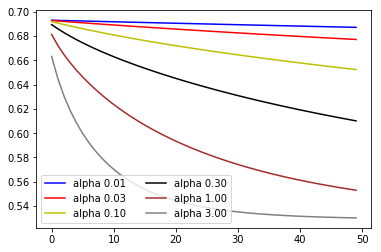

In [17]:
# To plot the J(theta) using different alphas
fig, ax = plt.subplots()
iterations = range(num_iters)

print('Running gradient descent ...\n')
for alpha, color in zip(alphas, colors):
    theta = np.zeros([n]) # reset the theta to the current alpha
    
    theta, J_history = regularizedLogisticGradientDescent(X, y, theta, alpha, lambd, num_iters)
    # print('alpha ', alpha, ' found theta ', theta)
    plt.plot(iterations, J_history, color=color, label='alpha %.2f' % alpha)
    
plt.legend(loc='best', ncol=2)

In [18]:
# Display gradient descent's result
print('Theta computed from gradient descent:');
# Expected ~= [ 1.426919, 3.391232, 3.142802]
print(theta);

Theta computed from gradient descent:
[ 1.14939373e+00  5.43456257e-01  1.08228488e+00 -1.83452932e+00
 -7.63086200e-01 -1.18620197e+00  8.01474746e-02 -3.19606192e-01
 -3.19321956e-01 -1.86550973e-01 -1.35820520e+00 -6.69062666e-02
 -5.48059858e-01 -2.23309559e-01 -1.10055025e+00 -2.46103649e-01
 -1.91530316e-01 -6.12851443e-02 -2.42855358e-01 -2.50526484e-01
 -5.02409135e-01 -9.83758798e-01  5.35681102e-03 -2.66701426e-01
  1.77645676e-03 -2.93642546e-01 -1.12672608e-01 -9.29374391e-01]


## ============= Part 4: Regularization and Boundary Decision =============
This time we gonna try different values of lambda and see how regularization affects the decision coundart.

In [19]:
def plot_boundary_decision(theta, x_min, x_max, y_min, y_max):
    xgrid = np.arange(x_min, x_max, (x_max - x_min) / 100)
    ygrid = np.arange(y_min, y_max, (y_max - y_min) / 100)

    X,Y = np.meshgrid(xgrid, ygrid) # grid of points
    gridPoints = np.c_[X.ravel(), Y.ravel()]

    predictions = np.zeros(len(gridPoints))
    for i in range(len(gridPoints)):
        mapped_point = mapFeature([[gridPoints[i][0]]], [[gridPoints[i][1]]])
        prob = hypothesis(mapped_point, theta)
        predictions[i] = 1 if prob >= 0.5 else 0

    return X, Y, predictions.reshape(X.shape)

Theta found using lambda  0
[ 2.2397063   1.49853402  2.44222853 -3.68444292 -2.26736034 -2.75070562
  0.487341   -0.89062048 -0.80516428 -0.23375743 -2.83231643 -0.14519475
 -1.28718694 -0.75307641 -2.3323904  -0.38871072 -0.49029014 -0.04697104
 -0.63760827 -0.74659804 -0.75442379 -2.09740762  0.04584817 -0.61020003
  0.024988   -0.70687313 -0.44420146 -1.75069477]
Theta found using lambda  1
[ 1.25435504  0.61504545  1.17019679 -1.99325668 -0.89237889 -1.38382159
  0.12013526 -0.36168021 -0.35764614 -0.17551884 -1.44935767 -0.06016388
 -0.6079651  -0.26706552 -1.18365948 -0.24121872 -0.20740448 -0.05255923
 -0.27258569 -0.29042007 -0.47165094 -1.0396542   0.01972212 -0.29075305
  0.01001994 -0.32349635 -0.1389982  -0.93811797]
Theta found using lambda  5
[ 5.26768641e-01  8.29939167e-02  3.51676483e-01 -7.63620247e-01
 -2.17028137e-01 -4.73419225e-01 -6.10039920e-02 -1.03760454e-01
 -1.12778328e-01 -1.35170435e-01 -5.64099257e-01 -2.16017782e-02
 -2.05408285e-01 -5.63669722e-02 -4.6

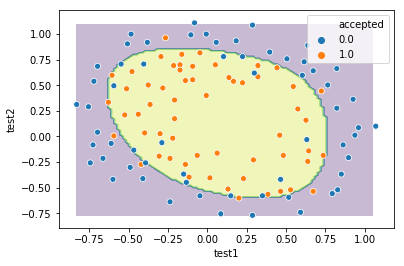

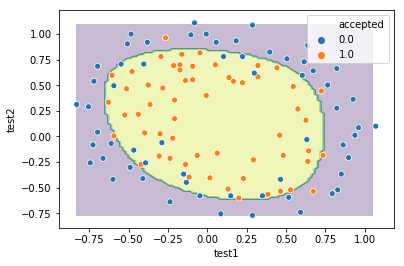

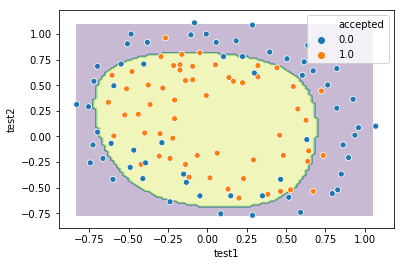

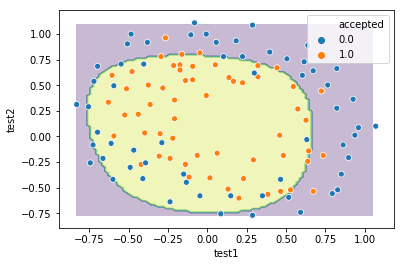

In [20]:
initial_theta = np.zeros([n])
alpha = 3
num_iters = 100
lambdas = [0, 1, 5, 10]

# Calculate the boundary decision
test1_min = x[:,0].min()
test1_max = x[:,0].max()
test2_min = x[:,1].min()
test2_max = x[:,1].max()

for i in range(len(lambdas)):
    lambd = lambdas[i]
    theta, _ = regularizedLogisticGradientDescent(X, y, initial_theta, alpha, lambd, num_iters)
    # theta = np.array([ 1.79571, -2.88733, 1.12066, -1.54554, -9.71673, 12.04460, 7.08675, 24.57407, 40.79083, 2.69598, 15.81996, -2.50585, -29.59604, -5.02291, -43.13834, 11.36623, -4.28287, 0.73731, -15.99184, -34.02226, 26.42723, -54.85742, -28.71752, -10.76192, 24.04492, -52.71023, -34.19925, -6.83135 ])
    print('Theta found using lambda ', lambd)
    print(theta)
    XX, YY, predictions = plot_boundary_decision(theta, test1_min, test1_max, test2_min, test2_max)

    fig, ax = plt.subplots()
    # setup plot for decision boundary (0 = Refused, 1 = Admitted)
    plt.contourf(XX, YY, predictions, alpha=0.3)
    sns.scatterplot('test1', 'test2', hue='accepted', style_order=[1,0], data=data)
    plt.legend()